Found 1650 files belonging to 2 classes.
Using 1320 files for training.
Found 1650 files belonging to 2 classes.
Using 330 files for validation.
Index(['filepath', 'label'], dtype='object')


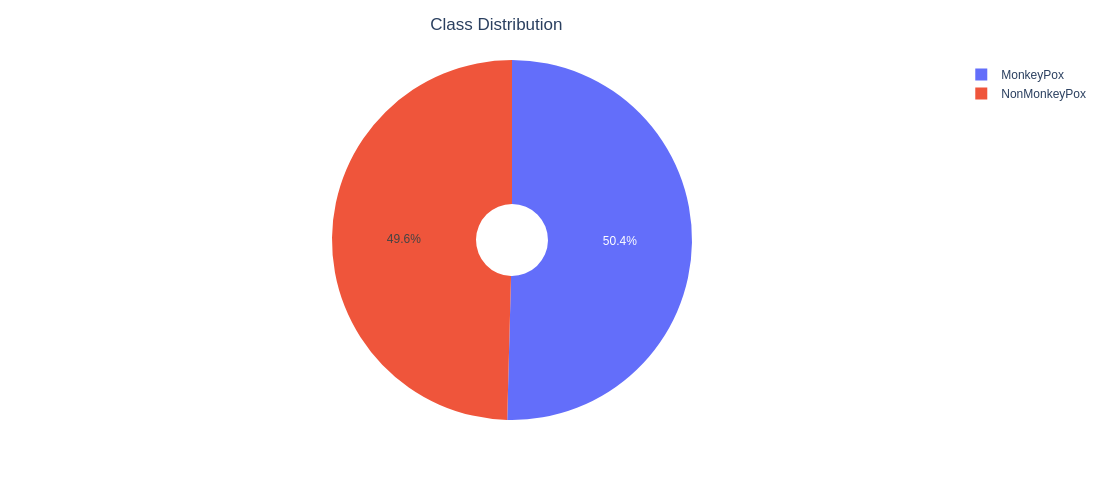

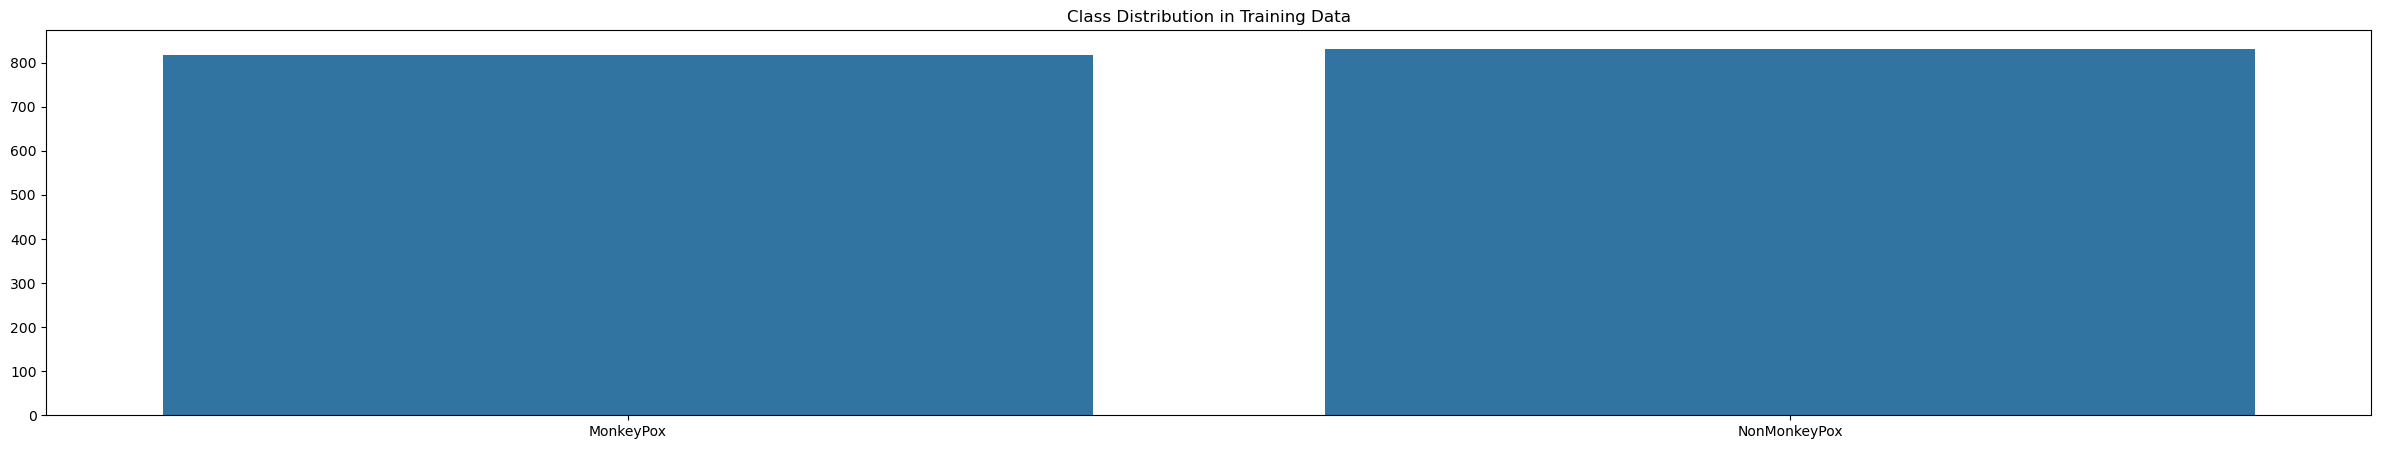

In [5]:
# Required Libraries
import numpy as np 
import pandas as pd 
import os
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optional - Install Plotly if not already installed
# !pip install plotly

# Plotly for visualization
import plotly.express as px

# Define image dimensions and batch size
image_height = 224
image_weight = 224
batch_size = 4

# Specify the path to your dataset
tpath = 'aug'  # Update this with your local path

# Load the training data using ImageDataGenerator
training_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=4,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

# Load the validation data
validation_data = keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=4,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

# Load the metadata information (Update the path)
info_file = 'labels_aug.csv'  # Update the path
info = pd.read_csv(info_file)
info.head()

# Check the column names to be sure
print(info.columns)

# Correct the pie chart code to use the lowercase 'label'
fig = px.pie(
    names=info['label'].unique(),  # Corrected to 'label'
    values=info['label'].value_counts(),  # Corrected to 'label'
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Class Distribution', 'x': 0.45}})
fig.show()

# Visualize class distribution in a bar plot
class_names = []
class_count = []
train_examples = 0

# Count the number of images per class
for f in os.listdir(tpath):
    files = gb.glob(pathname=str(tpath + "//" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)

# Display class distribution as a bar plot
plt.figure(figsize=(30, 5))
sns.barplot(x=class_names, y=class_count)
plt.title("Class Distribution in Training Data")
plt.show()


Found 1321 images belonging to 2 classes.


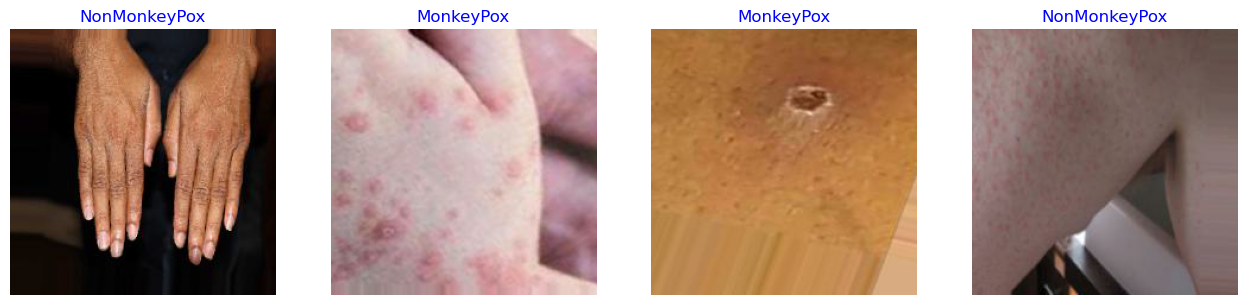

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset directory
tpath = "aug"  # Example: 'data/' containing 'monkeypox' and 'nonmonkeypox'

# Create an ImageDataGenerator for rescaling without augmentation
train_gen = ImageDataGenerator(
    rescale=1. / 255,             # Normalizes the pixel values to the range [0, 1]
    validation_split=0.2          # Splits 20% of the data for validation
)

# Load images from the directory for training
train_batch = train_gen.flow_from_directory(
    directory=tpath,
    target_size=(224, 224),        # Resize all images to 224x224
    batch_size=4,                 # Number of images to return in each batch
    subset='training',             # Specify as training data (80% of data)
    shuffle=True                   # Shuffle the images to randomize the batch
)

# Get class indices (which class corresponds to which folder)
g_dict = train_batch.class_indices  # Returns a dictionary like {'monkeypox': 0, 'nonmonkeypox': 1}
classes = list(g_dict.keys())       # List of class names: ['monkeypox', 'nonmonkeypox']

# Get a batch of images and labels
images, labels = next(train_batch)  # Fetch a batch of images and corresponding labels

# Determine the number of images to display (up to 30)
length = len(labels)        # Length of batch size (16 in this case)
sample = min(length, 25)    # Display up to 30 images (or batch size if smaller)

# Set up the plot for displaying images
plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i]      # Image from the batch
    plt.imshow(image)      # Display the image
    index = np.argmax(labels[i])  # Get the index of the class label (0 or 1)
    class_name = classes[index]   # Get the class name ('monkeypox' or 'nonmonkeypox')
    plt.title(class_name, color='blue', fontsize=12)  # Set title to class name
    plt.axis('off')        # Hide axis for better display

plt.show()


In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a Sequential model
InceptionV3_model = Sequential()

# Load the InceptionV3 model pre-trained on ImageNet, excluding the top layers
pretrained_model = InceptionV3(include_top=False,            # Exclude fully connected layers
                               input_shape=(224, 224, 3),    # Input shape (224x224 with 3 color channels)
                               pooling=None,                 # No pooling here; we'll add it below
                               weights='imagenet')           # Use ImageNet weights

# Fine-tune the last few layers of the pre-trained model
for layer in pretrained_model.layers[:-30]:  # Freeze all layers except the last 30
    layer.trainable = False

# Add the pre-trained InceptionV3 model to the Sequential model
InceptionV3_model.add(pretrained_model)

# Add Global Average Pooling
InceptionV3_model.add(GlobalAveragePooling2D())

# Add Batch Normalization for stabilization and faster training
InceptionV3_model.add(BatchNormalization())

# Add Dropout for regularization (helps avoid overfitting)
InceptionV3_model.add(Dropout(0.5))  # Dropout after pooling

# Add custom dense layers
InceptionV3_model.add(Dense(512, activation='relu'))  # Hidden dense layer

# Add Batch Normalization after the Dense layer
InceptionV3_model.add(BatchNormalization())

# Add another Dropout layer for regularization
InceptionV3_model.add(Dropout(0.4))  # Moderate dropout rate

# Output layer for binary classification (monkeypox vs. other)
InceptionV3_model.add(Dense(2, activation='softmax'))

# Display the model summary
InceptionV3_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_190         │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_191         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,863,138 (87.22 MB)

 Trainable params: 6,211,266 (23.69 MB)

 Non-trainable params: 16,651,872 (63.52 MB)

In [8]:
# Compile the model with Adam optimizer and L2 regularization to avoid overfitting
InceptionV3_model.compile(optimizer=Adam(learning_rate=0.0001),  # Higher learning rate for faster convergence
                          loss='sparse_categorical_crossentropy', 
                          metrics=['accuracy'])

# Introduce learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001, verbose=1)

# Model training with data augmentation
epochs = 40  # Increase epochs to give the model more learning time
history_inceptionLast = InceptionV3_model.fit(
    training_data,                # Training data generator
    validation_data=validation_data,  # Validation data generator
    epochs=epochs,                # Number of epochs
    callbacks=[reduce_lr],        # Callback for adaptive learning rate
    verbose=1                     # Print progress during training
)

# Save the trained model
InceptionV3_model.save('inceptionV3_last.h5')

Epoch 1/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.6066 - loss: 1.0643 - val_accuracy: 0.8333 - val_loss: 0.4171 - learning_rate: 1.0000e-04
Epoch 2/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 71s 215ms/step - accuracy: 0.6775 - loss: 0.8676 - val_accuracy: 0.8000 - val_loss: 0.5834 - learning_rate: 1.0000e-04
Epoch 3/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 71s 216ms/step - accuracy: 0.6962 - loss: 0.7725 - val_accuracy: 0.8273 - val_loss: 0.4048 - learning_rate: 1.0000e-04
Epoch 4/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 70s 213ms/step - accuracy: 0.6689 - loss: 0.7667 - val_accuracy: 0.8667 - val_loss: 0.3297 - learning_rate: 1.0000e-04
Epoch 5/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 72s 219ms/step - accuracy: 0.7420 - loss: 0.6191 - val_accuracy: 0.8576 - val_loss: 0.3653 - learning_rate: 1.0000e-04
Epoch 6/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 73s 221ms/step - accuracy: 0.7437 - loss: 0.5700 - val_accuracy: 0.8606 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 7/40
330/330 ━━━━━━━━━━━━━━━━━━━━ 75s 22

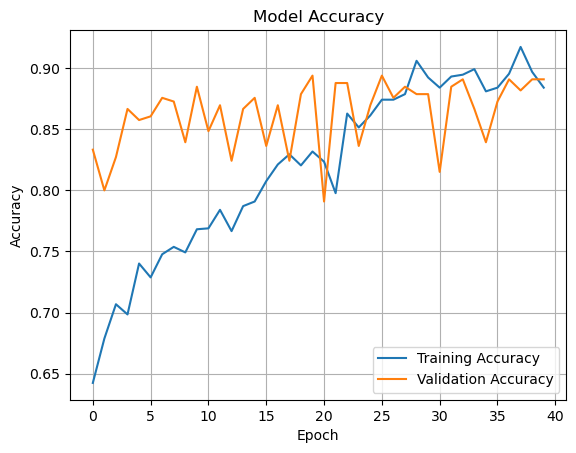

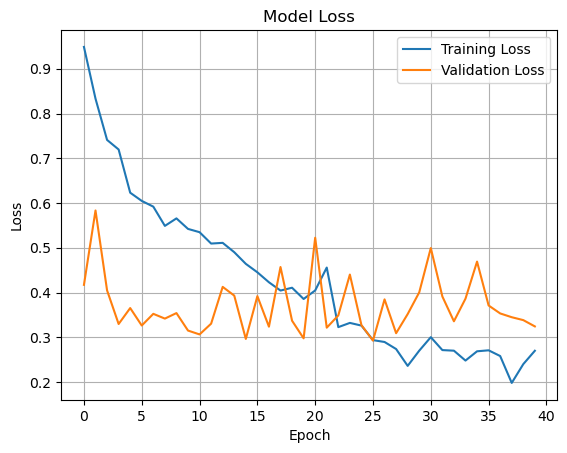

In [9]:
# Visualize training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history_inceptionLast.history['accuracy'], label='Training Accuracy')
plt.plot(history_inceptionLast.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Visualize training and validation loss
plt.plot(history_inceptionLast.history['loss'], label='Training Loss')
plt.plot(history_inceptionLast.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()